In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import collections
import copy

In [3]:
def plot_decision_boundary2(model, title):
    # given a linear model plot the decision boundary using the weights of the linear layer
    w = model[0].weight.data.numpy()
    b = model[0].bias.data.numpy()
    x = np.linspace(-3, 3, 100)
    y = -w[0][0]/w[0][1] * x - b[0]/w[0][1]
    plt.plot(x, y, label=title)
    plt.legend()

def plot_opt_decision_boundary(w, gamma, p):
    # given a linear model plot the decision boundary using the weights of the linear layer
    x = np.linspace(-3, 3, 100)
    y = -w[0]/w[1] * x - np.log(p/(1-p))/w[1]
    plt.plot(x, y, label="Optimal Decision Boundary")
    plt.legend()

In [4]:
def gen_data(n, d, w, gamma, p):
    ys = torch.distributions.Bernoulli(torch.tensor(p)).sample((n, 1))
    zs = torch.randn(n, d)
    xs = zs + gamma * (2*ys-1) * w
    return xs.float(), ys

In [5]:
def bayes_accuracy(xs, ys, w, gamma, p):
    temp = 1/(1+torch.exp(2*gamma*torch.matmul(xs, w)))
    preds = temp <= p
    return (preds == ys[:,0]).float().mean()

In [15]:
def train_on_source(xTrain, yTrain, xTest, yTest):
    '''
    Trains a logistic regression model on the source dataset and returns the model.
    '''
    model = nn.Sequential(nn.Linear(xTrain.shape[1], 1))
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for i in tqdm(range(10000)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xTrain))
        loss = F.binary_cross_entropy(outputs, yTrain)
        loss.backward()
        optimizer.step()
    return model

def adapt(model, xTarget, epochs = 100000):
    '''
    Adapts the model to the target dataset and returns the adapted model.
    Current code uses Adam since the SGD was very slow.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = model(xTarget)

        probsPred = torch.sigmoid(outputs)
        labelPreds = (probsPred > 0.5).float().detach()
        loss = F.binary_cross_entropy(probsPred, labelPreds)

        # labelPreds = (outputs > 0).float().detach()
        # loss = torch.mean(torch.clamp(1 - outputs.t() * labelPreds, min=0))
        # loss = torch.mean(torch.exp(-outputs.t() * labelPreds))
        loss.backward()
        optimizer.step()
    return model

In [12]:
def train_and_adapt(xSource, ySource, xTarget, lamb = 1, epochs = 100000):
    '''
    Trains a model on the source dataset and adapts it to the target dataset.
    Returns the adapted model.
    '''
    model = nn.Sequential(nn.Linear(xSource.shape[1], 1))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(xSource))
        classificationLoss = F.binary_cross_entropy(outputs, ySource)
        probPreds = torch.sigmoid(model(xTarget))
        labelPreds = (probPreds > 0.5).float().detach()
        selfTrainingLoss = F.binary_cross_entropy(probPreds, labelPreds)
        loss = classificationLoss + lamb * selfTrainingLoss
        loss.backward()
        optimizer.step()
    return model

In [9]:
def evaluate(model, x, y):
    return((model(x) > 0) == y).float().mean().item()

In [7]:
n = 1000
d = 2
w = torch.ones(d)/np.sqrt(d)
gamma = 0.3
pSource = 0.5
pTarget = 0.9

In [18]:
xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

In [19]:
bAccuSource = bayes_accuracy(xSourceTest, ySourceTest, w, gamma, pSource)
bAccuTarget = bayes_accuracy(xTargetTest, yTargetTest, w, gamma, pTarget)
print("Bayes accuracy on source is:", bAccuSource)
print("Bayes accuracy on target is:", bAccuTarget)

Bayes accuracy on source is: tensor(0.6570)
Bayes accuracy on target is: tensor(0.8940)


In [24]:
model = train_and_adapt(xSourceTrain, ySourceTrain, xTargetTrain)

print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 100000/100000 [00:35<00:00, 2790.79it/s]

Accuracy on source is: 0.6449999809265137
Accuracy on target is: 0.6809999942779541


In [20]:
model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

model = adapt(model, xTargetTrain)
print("Accuracy on source is:", evaluate(model, xSourceTest, ySourceTest))
print("Accuracy on target is:", evaluate(model, xTargetTest, yTargetTest))

100%|██████████| 10000/10000 [00:01<00:00, 6424.53it/s]


Accuracy on source is: 0.6480000019073486
Accuracy on target is: 0.6209999918937683


100%|██████████| 100000/100000 [00:23<00:00, 4194.86it/s]

Accuracy on source is: 0.6299999952316284
Accuracy on target is: 0.7570000290870667


In [29]:
reps = 20
selfTrainingAccus = []
pseudoLabelAccus = []
for i in range(reps):
    xSourceTrain, ySourceTrain = gen_data(n, d, w, gamma, pSource)
    xSourceTest, ySourceTest = gen_data(n, d, w, gamma, pSource)

    xTargetTrain, yTargetTrain = gen_data(n, d, w, gamma, pTarget)
    xTargetTest, yTargetTest = gen_data(n, d, w, gamma, pTarget)

    model = train_and_adapt(xSourceTrain, ySourceTrain, xTargetTrain, lamb = 0.4)
    pseudoLabelAccus.append(evaluate(model, xTargetTest, yTargetTest))

    model = train_on_source(xSourceTrain, ySourceTrain, xSourceTest, ySourceTest)
    model = adapt(model, xTargetTrain)
    selfTrainingAccus.append(evaluate(model, xTargetTest, yTargetTest))

print("Average accuracy of self-training is:", np.mean(selfTrainingAccus))
print("Average accuracy of pseudo-labeling is:", np.mean(pseudoLabelAccus))

100%|██████████| 100000/100000 [00:27<00:00, 3581.38it/s]

Average accuracy of self-training is: 0.7418000012636184
Average accuracy of pseudo-labeling is: 0.6539499938488007


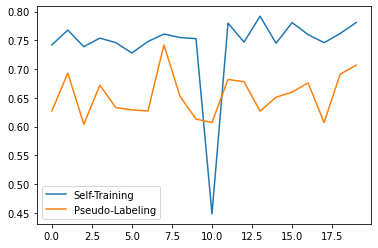

In [30]:
plt.plot(selfTrainingAccus, label="Self-Training")
plt.plot(pseudoLabelAccus, label="Pseudo-Labeling")
plt.legend()